In [46]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine, utils
import torchinfo

In [47]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [48]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [49]:
# Get a set of pretrained model weights
weights = torchvision.models.AlexNet_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [50]:
#HyperParameters
batch_Size = 4
learning_rate = 0.0001
epochS = 15
dropout_prob = 0.5

In [51]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [52]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1301d6e2930>,
 ['high', 'low', 'medium'])

In [53]:
model = torchvision.models.alexnet(weights=weights).to(device)

In [54]:
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.features.parameters():
#     param.requires_grad = False

In [55]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=9216, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [56]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [57]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  7%|▋         | 1/15 [00:18<04:17, 18.39s/it]

Epoch: 1 | train_loss: 1.1554 | train_acc: 0.3690 | test_loss: 0.9608 | test_acc: 0.5833


 13%|█▎        | 2/15 [00:39<04:22, 20.19s/it]

Epoch: 2 | train_loss: 0.8477 | train_acc: 0.5714 | test_loss: 0.7844 | test_acc: 0.7917


 20%|██        | 3/15 [01:00<04:07, 20.61s/it]

Epoch: 3 | train_loss: 0.6243 | train_acc: 0.7500 | test_loss: 0.6514 | test_acc: 0.6667


 27%|██▋       | 4/15 [01:20<03:41, 20.16s/it]

Epoch: 4 | train_loss: 0.4176 | train_acc: 0.8333 | test_loss: 0.5157 | test_acc: 0.7917


 33%|███▎      | 5/15 [01:40<03:21, 20.19s/it]

Epoch: 5 | train_loss: 0.2602 | train_acc: 0.9167 | test_loss: 0.5136 | test_acc: 0.7500


 40%|████      | 6/15 [01:59<02:57, 19.73s/it]

Epoch: 6 | train_loss: 0.1999 | train_acc: 0.9524 | test_loss: 0.4414 | test_acc: 0.7917


 47%|████▋     | 7/15 [02:18<02:35, 19.48s/it]

Epoch: 7 | train_loss: 0.1913 | train_acc: 0.9405 | test_loss: 0.3761 | test_acc: 0.8333


 53%|█████▎    | 8/15 [02:37<02:15, 19.32s/it]

Epoch: 8 | train_loss: 0.1648 | train_acc: 0.9405 | test_loss: 0.5364 | test_acc: 0.7500


 60%|██████    | 9/15 [02:56<01:55, 19.24s/it]

Epoch: 9 | train_loss: 0.0985 | train_acc: 0.9762 | test_loss: 0.4490 | test_acc: 0.7500


 67%|██████▋   | 10/15 [03:15<01:35, 19.18s/it]

Epoch: 10 | train_loss: 0.0490 | train_acc: 0.9762 | test_loss: 0.4169 | test_acc: 0.8750


 73%|███████▎  | 11/15 [03:35<01:17, 19.28s/it]

Epoch: 11 | train_loss: 0.0199 | train_acc: 1.0000 | test_loss: 0.3788 | test_acc: 0.8750


 80%|████████  | 12/15 [03:54<00:57, 19.21s/it]

Epoch: 12 | train_loss: 0.0173 | train_acc: 1.0000 | test_loss: 0.3794 | test_acc: 0.8750


 87%|████████▋ | 13/15 [04:13<00:38, 19.16s/it]

Epoch: 13 | train_loss: 0.0024 | train_acc: 1.0000 | test_loss: 0.4181 | test_acc: 0.8750


 93%|█████████▎| 14/15 [04:34<00:19, 19.74s/it]

Epoch: 14 | train_loss: 0.0031 | train_acc: 1.0000 | test_loss: 0.4425 | test_acc: 0.8750


100%|██████████| 15/15 [04:54<00:00, 19.66s/it]

Epoch: 15 | train_loss: 0.0008 | train_acc: 1.0000 | test_loss: 0.4446 | test_acc: 0.8750
[INFO] Total training time: 294.946 seconds


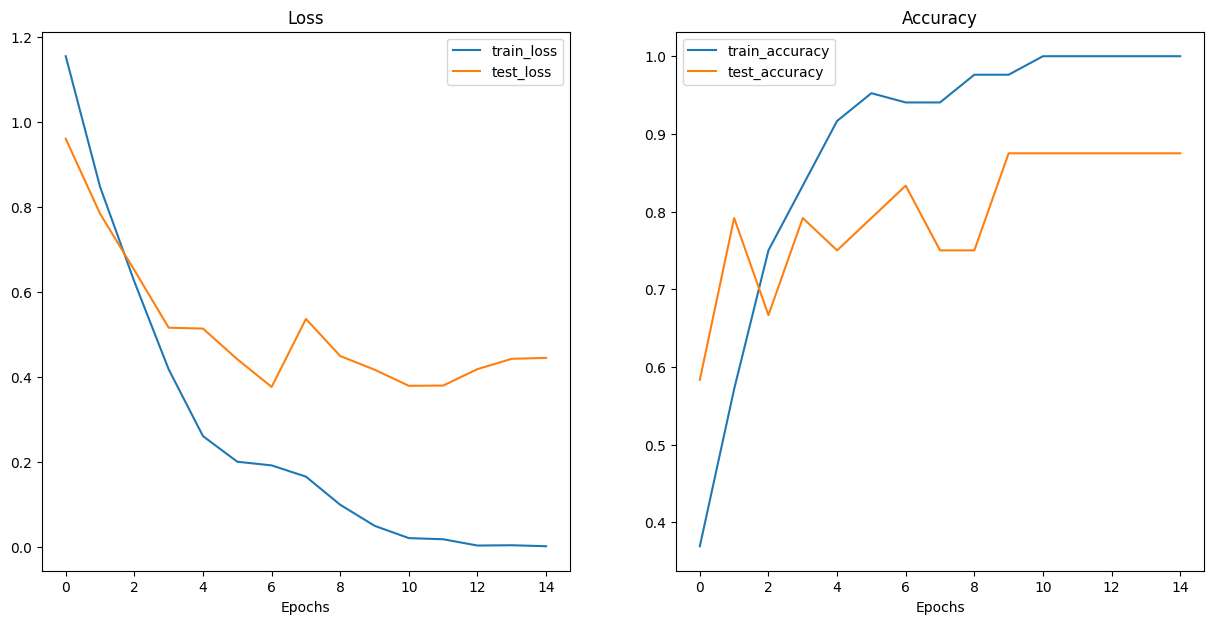

In [58]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

In [59]:
from winsound import Beep
Beep(300, 200)

In [60]:
# utils.save_model(model=model,
#                  target_dir="models",
#                  model_name="alexnet1.pth")